# Project 9: Florida Panther
From the book [Probability and Simulation by Giray Ökten](https://link.springer.com/book/10.1007/978-3-030-56070-6)

This project will model the population of the Florida Panther using estimated birth and death rates. The following data was manually compiled from the [Panther Pulse reports](https://myfwc.com/wildlifehabitats/wildlife/panther/pulse/).

> There are approximately 120-230 adult panthers in the population.

## Step 1.  Estimate the birth and death rates

The function we will use to model the population is

$x(n + 1) − x(n) = (b − d)x(n)$

where _x(n)_ denotes the population at time _n_, and _b_, _d_ are the birth and death rates
for the panther

In [2]:
# 1. load the data into a dataframe
# 2. add a column for the estimated "population growth"
# 3. add columns for lower and upper population estimates
# 4. add columns for estimated birth and death rates

In [3]:
using JuliaDB
using Statistics
using Distributions
using PyPlot

In [4]:
# 1. load the data into a dataframe
data=loadtable("panther_data.csv")

Table with 9 rows, 3 columns:
year  births  deaths
────────────────────
2014  32      33
2015  15      41
2016  14      41
2017  19      30
2018  9       30
2019  11      27
2020  11      22
2021  3       27
2022  3       27

In [5]:
# 2. add a column for the estimated yearly population growth, which is births - deaths
births = select(data, :births)
deaths = select(data, :deaths)
net_growth = births - deaths
data = insertcols(data, 4, :net_growth => net_growth)

Table with 9 rows, 4 columns:
year  births  deaths  net_growth
────────────────────────────────
2014  32      33      -1
2015  15      41      -26
2016  14      41      -27
2017  19      30      -11
2018  9       30      -21
2019  11      27      -16
2020  11      22      -11
2021  3       27      -24
2022  3       27      -24

In [6]:
# 3. add columns for lower and upper bound absolute population estimates
# we have the absolute population numbers for 2023, so we can work out the estimated absolute population numbers
# past years by starting with the numbers for 2023 and progressively subtracting the netgrowth. eg. if the
# max pop in 2023 was 230 panthers and the estimated net growth in 2022 was -24, then at the start of 2022
# the estimated population was 254
pop_2023_lower = 120
pop_2023_upper = 230
net_growth_values = select(data, :net_growth)

9-element Vector{Int64}:
  -1
 -26
 -27
 -11
 -21
 -16
 -11
 -24
 -24

In [7]:
pop_start_of_year_lower = reverse(accumulate(-, reverse(net_growth_values), init=pop_2023_lower))
data = insertcols(data, 5, :pop_start_lower => pop_start_of_year_lower)

Table with 9 rows, 5 columns:
year  births  deaths  net_growth  pop_start_lower
─────────────────────────────────────────────────
2014  32      33      -1          281
2015  15      41      -26         280
2016  14      41      -27         254
2017  19      30      -11         227
2018  9       30      -21         216
2019  11      27      -16         195
2020  11      22      -11         179
2021  3       27      -24         168
2022  3       27      -24         144

In [8]:
pop_start_of_year_upper = reverse(accumulate(-, reverse(net_growth_values), init=pop_2023_upper))
data = insertcols(data, 6, :pop_start_upper => pop_start_of_year_upper)

Table with 9 rows, 6 columns:
year  births  deaths  net_growth  pop_start_lower  pop_start_upper
──────────────────────────────────────────────────────────────────
2014  32      33      -1          281              391
2015  15      41      -26         280              390
2016  14      41      -27         254              364
2017  19      30      -11         227              337
2018  9       30      -21         216              326
2019  11      27      -16         195              305
2020  11      22      -11         179              289
2021  3       27      -24         168              278
2022  3       27      -24         144              254

In [9]:
# 4. add columns for estimated birth and death rates
# now we can estimate the birth and death rates because we have estimates of the absolute population numbers
births = select(data, :births)
deaths = select(data, :deaths)
pop_start_lower = select(data, :pop_start_lower)
pop_start_upper = select(data, :pop_start_upper)

data = insertcols(data, 7, :birth_rate_lower => births ./ pop_start_lower)
data = insertcols(data, 8, :birth_rate_upper => births ./ pop_start_upper)
data = insertcols(data, 9, :death_rate_lower => deaths ./ pop_start_lower)
data = insertcols(data, 10, :death_rate_upper => deaths ./ pop_start_upper)


Table with 9 rows, 10 columns:
Columns:
#   colname           type
─────────────────────────────
1   year              Int64
2   births            Int64
3   deaths            Int64
4   net_growth        Int64
5   pop_start_lower   Int64
6   pop_start_upper   Int64
7   birth_rate_lower  Float64
8   birth_rate_upper  Float64
9   death_rate_lower  Float64
10  death_rate_upper  Float64

In [10]:
select(data, (:year, :birth_rate_lower, :death_rate_lower, :birth_rate_upper, :death_rate_upper))

Table with 9 rows, 5 columns:
year  birth_rate_lower  death_rate_lower  birth_rate_upper  death_rate_upper
────────────────────────────────────────────────────────────────────────────
2014  0.113879          0.117438          0.0818414         0.084399
2015  0.0535714         0.146429          0.0384615         0.105128
2016  0.0551181         0.161417          0.0384615         0.112637
2017  0.0837004         0.132159          0.0563798         0.0890208
2018  0.0416667         0.138889          0.0276074         0.0920245
2019  0.0564103         0.138462          0.0360656         0.0885246
2020  0.0614525         0.122905          0.0380623         0.0761246
2021  0.0178571         0.160714          0.0107914         0.0971223
2022  0.0208333         0.1875            0.011811          0.106299

In [11]:
est_birth_rate = select(data, (:birth_rate_lower, :birth_rate_upper) => row -> mean(row))
est_death_rate = select(data, (:death_rate_lower, :death_rate_upper) => row -> mean(row))
data = insertcols(data, 11, :est_birth_rate => est_birth_rate)
data = insertcols(data, 12, :est_death_rate => est_death_rate)

Table with 9 rows, 12 columns:
Columns:
#   colname           type
─────────────────────────────
1   year              Int64
2   births            Int64
3   deaths            Int64
4   net_growth        Int64
5   pop_start_lower   Int64
6   pop_start_upper   Int64
7   birth_rate_lower  Float64
8   birth_rate_upper  Float64
9   death_rate_lower  Float64
10  death_rate_upper  Float64
11  est_birth_rate    Float64
12  est_death_rate    Float64

In [12]:
select(data, (:year, :est_birth_rate, :est_death_rate))

Table with 9 rows, 3 columns:
year  est_birth_rate  est_death_rate
────────────────────────────────────
2014  0.0978602       0.100918
2015  0.0460165       0.125778
2016  0.0467898       0.137027
2017  0.0700401       0.11059
2018  0.034637        0.115457
2019  0.0462379       0.113493
2020  0.0497574       0.0995148
2021  0.0143243       0.128918
2022  0.0163222       0.1469

## Step 2.  Estimate mean and std dev for birth and death rates

Use the available data to estimate the parameters $μ_{b}, μ_{d}, σ_{b}^2, σ_{d}^2$ using the sample mean and variance
of birth and death rate data.


In [13]:
birth_rate_sample_mean = mean(est_birth_rate)
birth_rate_sample_std_dev = std(est_birth_rate)
death_rate_sample_mean = mean(est_death_rate)
death_rate_sample_std_dev = std(est_death_rate)
birth_rate_sample_mean, birth_rate_sample_std_dev, death_rate_sample_mean, death_rate_sample_std_dev

(0.04688726873526156, 0.025710812425018284, 0.11984402647345499, 0.016052704837185443)

In [14]:
B = Normal(birth_rate_sample_mean, birth_rate_sample_std_dev)
D = Normal(death_rate_sample_mean, death_rate_sample_std_dev)

Normal{Float64}(μ=0.11984402647345499, σ=0.016052704837185443)

In [15]:
rand(B), rand(D)

(0.0051263081637560395, 0.11371770528764184)

## Step 3. Simulate population growth 

Compute $x(n)$ as $n = 1, 2, ..., 15$ using _b_ and _d_ sampled from their normal distributions.

In [16]:
# returns estimated population in n years given a starting population of pop_start
function x(pop_start, n)
    if n==0
        return pop_start
    end
    
    b = rand(B)
    d = rand(D)
    pop_next = pop_start + (b-d)*pop_start 
    
    return x(pop_next, n-1)
end

x (generic function with 1 method)

In [17]:
x(120, 15), x(230, 15)

(35.07635724523856, 74.7825674471199)

## Step 4. Generate some trajectories

In [18]:
# generate a trajectory so we can plot it
traj(pop_start, n) = map(years -> x(pop_start, years), 1:n)

traj (generic function with 1 method)

In [19]:
# returns a trajectory of growth for the next n years with starting population pop_start
# includes pop_start as the starting value
function traj(pop_start, n)
    trajectory = [ x(pop_start, years) for years in 1:n]
    insert!(trajectory, 1, pop_start)
    trajectory
end

traj (generic function with 1 method)

In [20]:
traj(120,3)

4-element Vector{Float64}:
 120.0
 116.8223785589331
 105.16673470252687
  93.37465688532285

In [21]:
# generate 10 trajectories for both lower and upper population start estimates
trajectories_lower = [ traj(120, 15) for i in 1:10 ] 
trajectories_upper = [ traj(230, 15) for i in 1:10 ] 
trajectories_lower[1]

16-element Vector{Float64}:
 120.0
 106.74376827965365
 103.14153155403278
  94.2158047849444
  77.82221802546756
  84.20291203165924
  76.13305282903208
  63.25377247296317
  70.65634781134709
  57.7009100472484
  61.48996085810593
  55.45744628338652
  36.912268491308794
  57.219432371707526
  42.68585247156294
  31.32905721250409

## Step 5. Plot trajectories

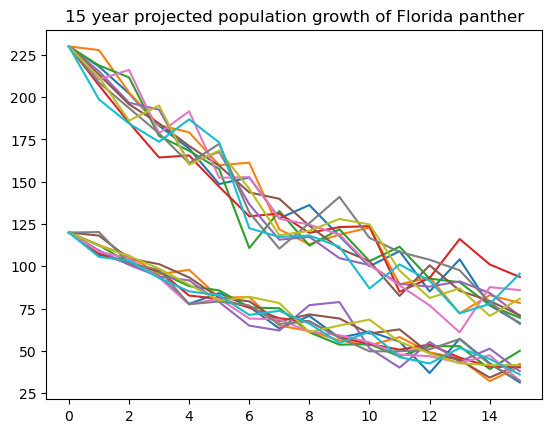

PyObject Text(0.5, 1.0, '15 year projected population growth of Florida panther')

In [37]:
x_axis = 0:15

for trajectory in vcat(trajectories_lower,trajectories_upper) 
    plot(x_axis, trajectory)
end

title("15 year projected population growth of Florida panther")